# Vehicle Detection and Tracking
In this project, our goal is to implement a pipeline to identify vehicles in a video from a front-facing camera on a car.

The pipeline is broken into 3 steps
* Build a classifier: to decide whether a square image is a car or not
* Sliding windows technique to search for vehicles in images
* Vehicle tracking: once we have a high confidence vehicle detection, we can eventually estimate where it will appear in each subsequent frame

We load some useful modules

In [31]:
import glob
import os
import numpy as np
import pandas as pd
import cv2
from skimage.feature import hog

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

## Build a car/noncar classifer
### Dataset
We have the following dataset

* Labeled data for [vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip) and [non-vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip)
* Additional labeled data from [Udacity](https://github.com/udacity/self-driving-car/tree/master/annotations) which contains data from [CrowdAI](https://s3.amazonaws.com/udacity-sdc/annotations/object-detection-crowdai.tar.gz) and from [Autti](https://s3.amazonaws.com/udacity-sdc/annotations/object-dataset.tar.gz)

In this project we start by using labeled data `vehicles.zip` and `non-vehicles.zip`. Let's do some data exploration

In [29]:
def list_imgs(imgdirs):
    imgfiles = []
    for imgdir in imgdirs:
        fns = glob.glob('{}/*.png'.format(imgdir))
        imgfiles += fns
    return imgfiles

cars = list_imgs(['datas/vehicles/GTI_Left',
                  'datas/vehicles/GTI_Right'
                  'datas/vehicles/GTI_MiddleClose',
                  'datas/vehicles/GTI_Far',
                  'datas/vehicles/KITTI_extracted'])
noncars = list_imgs(['datas/non-vehicles/GTI',
                     'datas/non-vehicles/Extras'])

print('Number of car samples     {}'.format(len(cars)))
print('Number of non-car samples {}'.format(len(noncars)))

# create pd.DataFrame and save it to csv
flags = [1]*len(cars) + [0]*len(noncars)
dataset = pd.DataFrame({'file':cars+noncars, 'is_car':flags})
dataset.to_csv('datas/dataset.csv', index=False)

Number of car samples     7709
Number of non-car samples 8968


Let check the shape of input images

In [26]:
a_car_sample = mpimg.imread(cars[0])
print('Shape of car sample    {} of type {}'.format(a_car_sample.shape, a_car_sample.dtype))
a_noncar_sample = mpimg.imread(noncars[0])
print('Shape of noncar sample {} of type {}'.format(a_noncar_sample.shape, a_noncar_sample.dtype))

print('\nInput max/min {:.3f}/{:.3f}'.format(np.max(a_car_sample), np.min(a_car_sample)))

Shape of car sample    (64, 64, 3) of type float32
Shape of noncar sample (64, 64, 3) of type float32

Input max/min 1.000/0.027


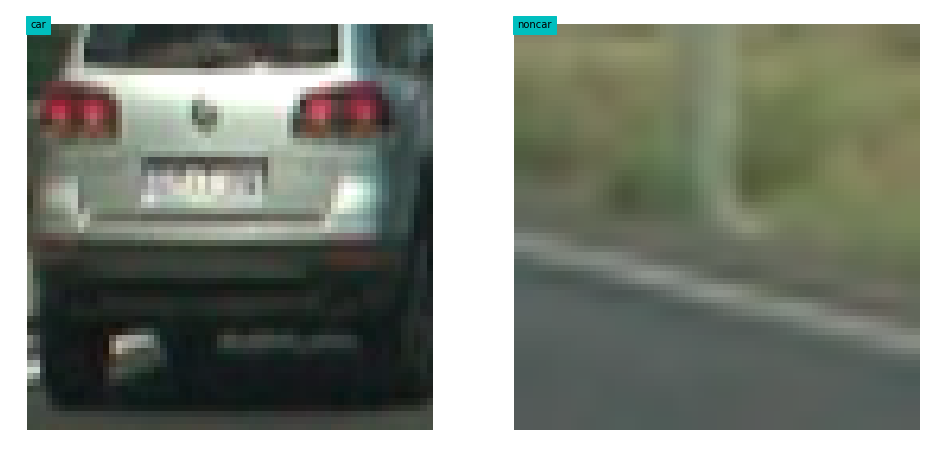

In [46]:
def show_img(img, label, ax = None):
    '''
    this function show image & label
    '''
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    
    # draw image
    if label is not None:
        ax.text(0, 0, label, color='k',backgroundcolor='c', fontsize=10)
    
    ax.imshow(img)
    ax.axis('off')

def view_imgs(imgs, labels, figsize, multi_col = True, sharex = True, sharey = True):
    nrows = 1 if multi_col else len(labels)
    ncols = len(labels) if multi_col else 1
    fig, axes = plt.subplots(figsize= figsize, nrows=nrows, ncols=ncols, sharey=sharex, sharex=sharey)
    for i, ax in enumerate(axes.flatten()):
        show_img(imgs[i], labels[i], ax)
        
view_imgs([a_car_sample, a_noncar_sample], ['car', 'noncar'], (16,8))        

So the input is of type `png` and when readed by `mpimg`, each sample is a `RGB` of shape `(64,64,3)` with each cell has value between [0.0, 1.0].

Let's split dataset into training set & test set

In [30]:
# split with shuffle (via DataFrame.sample)
train, valid = np.split(dataset.sample(frac=1, random_state = 45), [int(0.8* len(dataset))])

# create dataframe
train = pd.DataFrame(train.values, columns=dataset.columns)
valid = pd.DataFrame(valid.values, columns=dataset.columns)

### Features
The next step in building our car/noncar classifier is to build a set of features to be used as `input` for our classifier. As suggested in the project page, one could combine color-based features and shape-based features:

* color-based features: histograms of color and spatial binning of color
* shape-based features: HOG features

Let's implement these features

In [38]:
def feat_bin_spatial(img, size=(32,32)):
    # use cv2.resize then .ravel() to create the feature vector
    return cv2.resize(img, size).ravel()

def feat_color_hist(img, nbins=32, bins_range=(0.0, 1.0)):
    # get histogram for each channel
    ch1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ch2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    ch3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    # return the feature vector
    return np.concatenate([ch1_hist[0], ch2_hist[0], ch3_hist[0]])

def feat_hog(img, orient, pix_per_cell, cell_per_block, feat_vec = True, vis = False):
    '''
    this function computes the hog feature
    note that if vis=True, it returns features, hog_image, otherwise it returns features
    '''
    return hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), 
               cells_per_block=(cell_per_block, cell_per_block), feature_vector=feat_vec, visualise=vis)

Let's visualize these features

#### Histogram of color
We visualize histogram of color of car v.s non-car sample

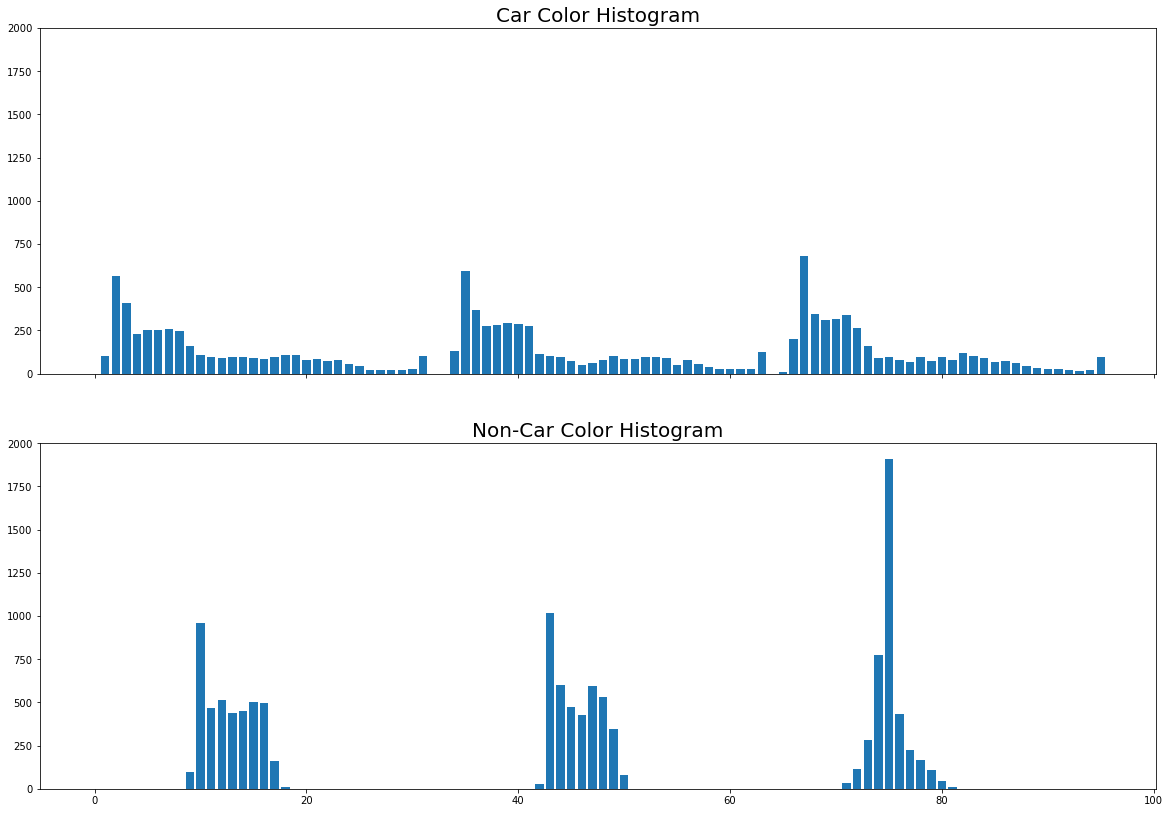

In [66]:
def visualize_hist(img_car, img_noncar, figsize):    
    hist_car = feat_color_hist(img_car, bins_range=(0.0, 1.0))
    hist_noncar = feat_color_hist(img_noncar, bins_range=(0.0, 1.0))
    x = np.arange(len(hist_car))
    
    fig, axes = plt.subplots(figsize= figsize, nrows=2, ncols=1, sharey=True, sharex=True)
    ax1, ax2 = axes.flatten()
    ax1.bar(x, hist_car)
    ax1.set_title('Car Color Histogram', fontsize=20)
    ax2.bar(x, hist_noncar)
    ax2.set_title('Non-Car Color Histogram', fontsize=20)

visualize_hist(a_car_sample, a_noncar_sample, (20,14))

For above example, histogram of car v.s non-car are quite different.

#### HOG feature
Let's view HOG of a car vs non-car

/home/minhvu/workplaces/infra/anaconda3/envs/tf_gpu_head/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


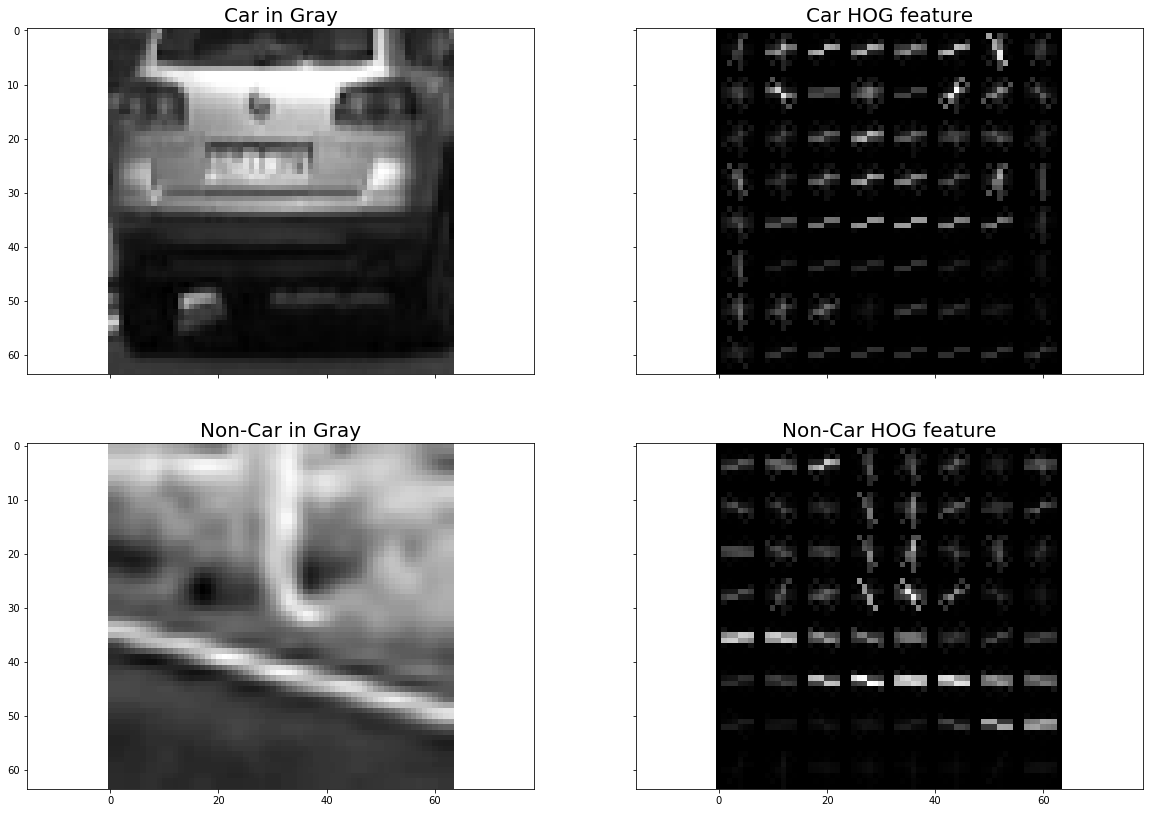

In [70]:
def visualize_hog(img_car, img_noncar, figsize):
    gray_car = cv2.cvtColor(img_car, cv2.COLOR_RGB2GRAY)
    gray_noncar = cv2.cvtColor(img_noncar, cv2.COLOR_RGB2GRAY)
    # Define HOG parameters
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    _, hog_car = feat_hog(gray_car, orient, pix_per_cell, cell_per_block, feat_vec=False, vis=True)
    _, hog_noncar = feat_hog(gray_noncar, orient, pix_per_cell, cell_per_block, feat_vec=False, vis=True)
    
    # draw image
    fig, axes = plt.subplots(figsize= figsize, nrows=2, ncols=2, sharey=True, sharex=True)
    ax1, ax2, ax3, ax4 = axes.flatten()
    ax1.imshow(gray_car, cmap='gray')
    ax1.set_title('Car in Gray', fontsize=20)
    ax2.imshow(hog_car, cmap='gray')
    ax2.set_title('Car HOG feature', fontsize=20)
    ax3.imshow(gray_noncar, cmap='gray')
    ax3.set_title('Non-Car in Gray', fontsize=20)
    ax4.imshow(hog_noncar, cmap='gray')
    ax4.set_title('Non-Car HOG feature', fontsize=20)
    
visualize_hog(a_car_sample, a_noncar_sample, (20,14))

The HOG feature will capture the shape of the object indepedent of the color so it might be more robust than color-based feature.

#### Spatial binning feature
The spatial binning feature is of high dimensional and it's not easy to visualize it. We skip it for now.

#### Combine features and normalize them
Now let's combine the above features and normalize them via `StandardScaler`

In [71]:
def img_features(img, cspace='RGB', spatial_size=(32,32), hist_bin=32, hist_range=(0., 1.0)):
    pass